# Scikit-learn tutorial: Predictive Analytics with Python

The Python programming language is a great option for data science and predictive analytics, as it comes equipped with multiple packages which cover most of your data analysis needs. For machine learning in Python, Scikit-learn (sklearn) is a great option and is built on NumPy, SciPy, and Matplotlib (N-dimensional arrays, scientific computing, and data visualization respectively). 

In this tutorial, you'll see how you can easily load in data from a database with `sqlite3`, how you can explore your data and improve its data quality with `pandas` and `matplotlib`, and how you can then use the Scikit-Learn package to extract some valid insights out of your data.

If you would like to take a machine learning course, check out DataCamp's [Supervised Learning with scikit-learn](https://www.datacamp.com/courses/supervised-learning-with-scikit-learn) course.


## Part 1: Predicting MLB Team Wins per Season

In this tutorial, you’ll test out several machine learning models from `sklearn` to predict the number of games that a Major League Baseball team won that season, based on the teams statistics and other variables from that season. If I were a gambling man ([and I most certainly am a gambling man]( http://www.sharpdata.co/online-poker-pro-to-data-science-jedi-master/)), I could build a model using historic data from previous seasons to forecast the upcoming one. Given the time series nature of the data, you could generate indicators such as average wins per year over the previous five years to make a highly accurate model. That is outside the scope of this tutorial, however and you will treat each row as independent. Each row of our data will consist of a single team for a specific year.

Sean Lahman compiled this data on his [website](http://www.seanlahman.com/baseball-archive/statistics/) and it was transformed to a [sqlite database here](https://github.com/jknecht/baseball-archive-sqlite).

### Importing Data

You will read in our data by querying a sqlite database using the `sqlite3` package and converting to a dataframe with `pandas`.  Your data will be filtered to only include currently active modern teams and only years where the team played 150 or more games.

First, download the file "lahman2016.sqlite" ([download here](https://github.com/jknecht/baseball-archive-sqlite/blob/master/lahman2016.sqlite)). Load `Pandas` and rename to `pd` for efficiency sake. You might remember that `pd` is the common alias for Pandas. Load `sqlite3` and connect to the database.

In [208]:
# Connecting to SQLite Database
import pandas as pd
import sqlite3
conn = sqlite3.connect("lahman2016.sqlite")

Next, you write a query, execute it and fetch the results.  Using `pandas`, you then convert the results to a DataFrame and print the first 5 rows using the `head()` method. 

**Tip:** If you want to learn more about using SQL with Python, consider taking DataCamp’s [Introduction to Databases in Python](https://www.datacamp.com/courses/introduction-to-relational-databases-in-python)

In [209]:
# Querying Database for all seasons where a team played 150 or more games and is still active today. 
# Creating dataframe from query.
query = '''select * from Teams 
inner join TeamsFranchises
on Teams.franchID == TeamsFranchises.franchID
where Teams.G >= 150 and TeamsFranchises.active == "Y";
'''
Teams = conn.execute(query).fetchall()
teams_df = pd.DataFrame(Teams)
print(teams_df.head())

     0   1    2    3     4   5    6     7   8   9   ...        42   43   44  \
0  1961  AL  LAA  ANA  None   8  162  82.0  70  91  ...    603510  111  112   
1  1962  AL  LAA  ANA  None   3  162  81.0  86  76  ...   1144063   97   97   
2  1963  AL  LAA  ANA  None   9  161  81.0  70  91  ...    821015   94   94   
3  1964  AL  LAA  ANA  None   5  162  81.0  82  80  ...    760439   90   90   
4  1965  AL  CAL  ANA  None   7  162  80.0  75  87  ...    566727   97   98   

    45   46   47   48                             49  50    51  
0  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
1  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
2  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
3  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
4  CAL  CAL  CAL  ANA  Los Angeles Angels of Anaheim   Y  None  

[5 rows x 52 columns]


Each of the columns contain data related to a specific team and year.  Some of the more important variables are listed below.  A full list of the variables can be found [here](https://github.com/Sharp-Data/Predicting-MLB-Wins/blob/master/readme2014.txt).

*  `yearID` - Year
*  `teamID` - Team
*  `franchID` - Franchise (links to TeamsFranchise table)
*  `G` - Games played
*  `W` - Wins
*  `LgWin` - League Champion(Y or N)
*  `WSWin` - World Series Winner (Y or N)
*  `R` - Runs scored
*  `AB` - At bats
*  `H` - Hits by batters
*  `HR` - Homeruns by batters
*  `BB` - Walks by batters
*  `SO` - Strikeouts by batters
*  `SB` - Stolen bases
*  `CS` - Caught stealing
*  `HBP` - Batters hit by pitch
*  `SF` - Sacrifice flies
*  `RA` - Opponents runs scored
*  `ER` - Earned runs allowed
*  `ERA` - Earned run average
*  `CG` - Complete games
*  `SHO` - Shutouts
*  `SV` - Saves
*  `IPOuts` - Outs Pitched (innings pitched x 3)
*  `HA` - Hits allowed
*  `HRA` - Homeruns allowed
*  `BBA` - Walks allowed
*  `SOA` - Strikeouts by pitchers
*  `E` - Errors
*  `DP` - Double Plays
*  `FP` - Fielding  percentage
*  `name` - Team's full name

For those of you who maybe aren't that familiar to baseball, here's a small story of how the game works, with the variables included :) 

Baseball is played between two teams (which you'll find back in the data by `name` or `teamID`) of nine players each. These two teams take turns batting and fielding. 

**[Could you help me with the following? I have never seen baseball :( ]**

The batting team attempts to score runs by hitting a ball that is thrown by the pitcher with a bat swung by the batter, then running counter-clockwise around a series of four bases: first, second, third, and home plate. A run is scored when a player advances around the bases and returns to home plate.
Players on the batting team take turns hitting against the pitcher of the fielding team, which tries to prevent runs by getting hitters out in any of several ways. A player on the batting team who reaches a base safely can later attempt to advance to subsequent bases during teammates' turns batting, such as on a hit or by other means. The teams switch between batting and fielding whenever the fielding team records three outs. One turn batting for both teams, beginning with the visiting team, constitutes an inning. A game is composed of nine innings, and the team with the greater number of runs at the end of the game wins. Baseball has no game clock, although almost all games end in the ninth inning.


### Cleaning and Preparing our Data

As you can see above, the DataFrame doesn't have column headers.  You can add headers by passing a list of your headers to the  `pandas` `.columns` attribute.

In [210]:
# Adding column names to dataframe
cols = ["yearID","lgID","teamID","franchID","divID","Rank","G","Ghome","W",
"L","DivWin","WCWin","LgWin","WSWin","R","AB","H","2B","3B","HR","BB","SO","SB",
"CS","HBP","SF","RA","ER","ERA","CG","SHO","SV","IPouts","HA","HRA","BBA",
"SOA","E","DP","FP","name","park","attendance","BPF","PPF","teamIDBR","teamIDlahman45",
"teamIDretro","franchID","franchName","active","NAassoc"]
teams_df.columns = cols
print(teams_df.head())

   yearID lgID teamID  franchID divID  Rank    G  Ghome   W   L   ...     \
0    1961   AL    LAA       ANA  None     8  162   82.0  70  91   ...      
1    1962   AL    LAA       ANA  None     3  162   81.0  86  76   ...      
2    1963   AL    LAA       ANA  None     9  161   81.0  70  91   ...      
3    1964   AL    LAA       ANA  None     5  162   81.0  82  80   ...      
4    1965   AL    CAL       ANA  None     7  162   80.0  75  87   ...      

  attendance  BPF  PPF teamIDBR  teamIDlahman45  teamIDretro  franchID  \
0     603510  111  112      LAA             LAA          LAA       ANA   
1    1144063   97   97      LAA             LAA          LAA       ANA   
2     821015   94   94      LAA             LAA          LAA       ANA   
3     760439   90   90      LAA             LAA          LAA       ANA   
4     566727   97   98      CAL             CAL          CAL       ANA   

                      franchName  active  NAassoc  
0  Los Angeles Angels of Anaheim       Y     N

The `len()` function will let you know how many rows you're dealing with.

In [211]:
print(len(teams_df))

2287


2,287 is not a huge number of data points to work with, so hopefully there aren't too many null values. Prior to assessing the data quality, let's first eliminate the columns that aren't necessary or are derived from the target column (`W` or Wins).  

This is where knowledge of the data you are working with starts to become very valuable.  It doesn't matter how much you know about coding or statistics if you don't have any knowledge of the data that you're working with. Being a lifelong baseball fan certainly helped me with this particular project.

In [212]:
# Dropping our unnecesary column variables.
drop_cols = ["lgID","franchID","divID","Rank","Ghome","L","DivWin","WCWin","LgWin","WSWin","SF","name","park","attendance","BPF","PPF","teamIDBR","teamIDlahman45",
"teamIDretro","franchID","franchName","active","NAassoc"]
df = teams_df.drop(drop_cols, axis=1)

As you read above, null values influence the data quality, which in turn can cause issues with machine learning algorithms. That's why you'll remove those next. There are a few ways to eliminate null values, but it might be a better idea to first display the count of null values for each column so you can decide how to best handle them.

In [213]:
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 0, 419, 1777, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0]


And here's where you'll see a trade-off: you need clean data, but you also don't have a large amount of data to spare. Two of the columns have a relatively small amount of null values. There are 110 null values in the `SO` (Strike Outs) column and 22 in the `DP` (Double Play) column.  

Two of the columns have a relatively large amount of them. There are 419 null values in the "CS" (Caught Steeling) column and 1777 in the `HBP` (Hit by Pitch) column. If you eliminate the rows where the columns have a small number of null values, you're losing a little over five percent of our data. 

Since you're trying to predict wins, runs scored and runs allowed are highly correlated with the target.  You want data in those columns to be very accurate. Strike outs and double plays aren't as important. 

I think you're better off keeping the rows and filling the null values with with the median value from each of the columns by using the `fillna()` method. Caught stealing and hit by pitch aren't very important variables either.  With so many null values in these columns, it's best to eliminate the columns all together.

In [214]:
# Eliminating rows with null values
df = df.drop(["CS","HBP"], axis=1)

In [215]:
# Filling null values
df["SO"] = df["SO"].fillna(df["SO"].median())
df["DP"] = df["DP"].fillna(df["DP"].median())
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Exploring and Visualizing Our Data

Now that you've cleaned up our data, you can do some exploration. You can get a better feel for the data set with a few simple visualizations.  [`matplotlib`](http://matplotlib.org/) is an excellent library for data visualization. You import `matplotlib.pyplot` and rename it as `plt` for efficiency. If you're working with a Jupyter notebook, you need to use the  `%matplotlib inline` magic.  You'll start by plotting a histogram of the target column so you can see the distribution of wins.

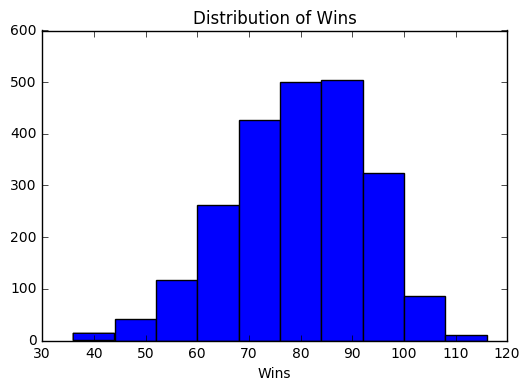

In [216]:
# Plotting distribution of wins
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(df["W"])
plt.xlabel('Wins')
plt.title('Distribution of Wins')
plt.show()

Print out the average wins per year.  You can use the `mean()` method for this.

In [217]:
print(df["W"].mean())

79.23043288150416


It can be useful to create bins for your target column while exploring your data, but you need to make sure not to include any feature that you generate from your target column when you train the model.  Including a column of labels generated from the target column in your training set would be like giving your model the answers to the test.

To create your win labels, you'll create a function called `assign_win_bins` which will take in an integer value (wins) and return an integer of 1-5 depending on the input value. Next you'll create a new column `win_bins` by using the `apply()` method on the wins column and passing in the `assign_win_bins()` function.

In [218]:
# Creating bins for the win column
def assign_win_bins(W):
    if W < 50:
        return 1
    if W >= 50 and W <= 69:
        return 2
    if W >= 70 and W <= 89:
        return 3
    if W >= 90 and W <= 109:
        return 4
    if W >= 110:
        return 5
    
df["win_bins"] = df["W"].apply(assign_win_bins)

Now let's make a scatter graph with the year on the x-axis and wins on the y-axis and highlight the `win_bins` column with colors.

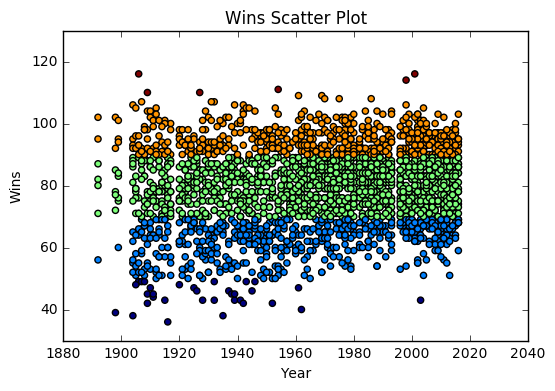

In [219]:
plt.scatter(df["yearID"], df["W"], c=df['win_bins'])
plt.title('Wins Scatter Plot')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.show()

As you can see in the above scatter plot, there are very few seasons from before 1900 and the game was much different back then. Because of that, it makes sense to eliminate those rows from the data set.

In [220]:
df = df[df["yearID"] > 1900]

When dealing with continuous data and creating linear models, integer values such as a year can cause issues.  It is unlikely that the number 1950 will have the same relationship to the the rest of the data that the model will infer.  You can avoid these issues by creating new variables that label the data based on the `yearID` value.

Anyone who follows the game of baseball knows that, as Major League Baseball (MLB) progressed, different eras emerged where the amount of runs per game increased or decreased significantly.  The dead ball era of the early 1900s is an example of a low scoring era and the steroid era at the turn of the 21st century is an example of a high scoring era.  Let's make a graph below that indicates how much scoring there was for each year.

You'll start by creating dictionaries `runs_per_year` and `games_per_year`.  Loop through the dataframe using the `iterrows()` method.  Populate the `runs_per_year` dictionary with years as keys and how many runs were scored that year as the value.  Populate the `games_per_year` dictionary with years as keys and how many games were played that year as the value.

In [221]:
runs_per_year = {}
games_per_year = {}
for i, row in df.iterrows():
    year = row["yearID"]
    runs = row["R"]
    games = row["G"]
    if year in runs_per_year:
        runs_per_year[year] = runs_per_year[year] + runs
        games_per_year[year] = games_per_year[year] + games
    else:
        runs_per_year[year] = runs
        games_per_year[year] = games

Next, create a dictionary called `mlb_runs_per_game`.  Iterate through the `games_per_year` dictionary with the `items()` method.  Populate the `mlb_runs_per_game` dictionary with years as keys and the amount of runs scored per game, league wide, as the value.

In [222]:
mlb_runs_per_game = {}
for k, v in games_per_year.items():
    year = k
    games = v
    runs = runs_per_year[year]
    mlb_runs_per_game[year] = runs / games

Finally, create your plot fromn the `mlb_runs_per_game` dictionary by putting the years on the x-axis and runs per game on the y-axis.

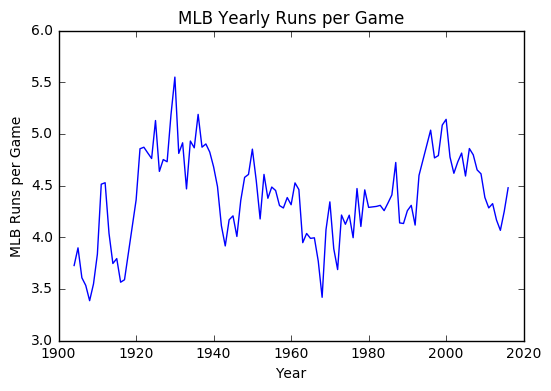

In [223]:
lists = sorted(mlb_runs_per_game.items())
x, y = zip(*lists)
plt.plot(x, y)
plt.title('MLB Yearly Runs per Game')
plt.xlabel('Year')
plt.ylabel('MLB Runs per Game')
plt.show()

### Adding New Features

Now that you have a better idea of scoring trends, you can create new variables that indicate a specific era that each row of data falls in based on the `yearID`.  You'll follow the same process as you did above when you created the `win_bins` column.  This time however, you will create dummy columns; a new column for each era.  You can use the `get_dummies()` method for this.

In [224]:
# Creating "year_label" column, which will give your algorithm information about how certain years are related (Dead ball eras, Live ball/Steroid Eras)

def assign_label(year):
    if year < 1920:
        return 1
    elif year >= 1920 and year <= 1941:
        return 2
    elif year >= 1942 and year <= 1945:
        return 3
    elif year >= 1946 and year <= 1962:
        return 4
    elif year >= 1963 and year <= 1976:
        return 5
    elif year >= 1977 and year <= 1992:
        return 6
    elif year >= 1993 and year <= 2009:
        return 7
    elif year >= 2010:
        return 8
    
df["year_label"] = df["yearID"].apply(assign_label)
dummy_df = pd.get_dummies(df["year_label"], prefix="era")
df = pd.concat([df, dummy_df], axis=1)

In [225]:
def assign_mlb_rpg(year):
    return mlb_runs_per_game[year]

df["mlb_rpg"] = df["yearID"].apply(assign_mlb_rpg)

Now you'll convert the years into decades by creating dummy columns for each decade.  Then you can drop the columns that you don't need anymore.

In [226]:
# Converting years into decade bins and creating dummy variables
def assign_decade(year):
    if year < 1920:
        return 1910
    elif year >= 1920 and year <= 1929:
        return 1920
    elif year >= 1930 and year <= 1939:
        return 1930
    elif year >= 1940 and year <= 1949:
        return 1940
    elif year >= 1950 and year <= 1959:
        return 1950
    elif year >= 1960 and year <= 1969:
        return 1960
    elif year >= 1970 and year <= 1979:
        return 1970
    elif year >= 1980 and year <= 1989:
        return 1980
    elif year >= 1990 and year <= 1999:
        return 1990
    elif year >= 2000 and year <= 2009:
        return 2000
    elif year >= 2010:
        return 2010
    
df["decade_label"] = df["yearID"].apply(assign_decade)
decade_df = pd.get_dummies(df["decade_label"], prefix="decade")
df = pd.concat([df, decade_df], axis=1)

In [227]:
df = df.drop(["yearID","year_label","decade_label"], axis=1)

The bottom line in the game of baseball is how many runs you score and how many runs you allow.  You can significantly increase the accuracy of your model by creating columns which are ratios of other columns of data.  

Runs per game and runs allowed per game will be great features to add to our data set.  `Pandas` makes this very simple as you create a new column by dividing the `R` column by the `G` column to create the `R_per_game` column.  

In [228]:
# Creating new features for Runs per Game and Runs Allowed per Game
df["R_per_game"] = df["R"] / df["G"]
df["RA_per_game"] = df["RA"] / df["G"]

Take a look at how each of the two new variables relate to the target wins column by making a couple scatter graphs.  Plot the runs per game on the x-axis of one graph and runs allowed per game on the x-axis of the other.  Plot the wins column on each y-axis.

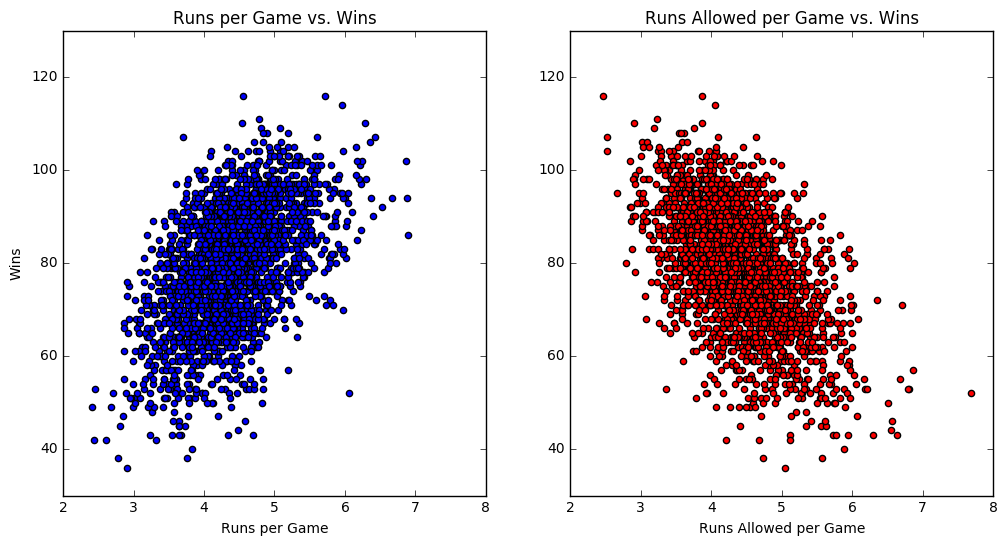

In [229]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(df["R_per_game"], df["W"], c="blue")
ax1.set_title('Runs per Game vs. Wins')
ax1.set_ylabel('Wins')
ax1.set_xlabel('Runs per Game')
ax2.scatter(df["RA_per_game"], df["W"], c="red")
ax2.set_title('Runs Allowed per Game vs. Wins')
ax2.set_xlabel('Runs Allowed per Game')
plt.show()

Before getting into any machine learning models, it can be useful to see how each of the variables is correlated with the target variable.  `Pandas` makes this easy with the `corr()` method.

In [230]:
df.corr()["W"]

G              0.178958
W              1.000000
R              0.551504
AB             0.233996
H              0.380281
2B             0.262323
3B             0.016970
HR             0.312713
BB             0.345348
SO             0.072069
SB             0.133300
RA            -0.518313
ER            -0.372580
ERA           -0.425833
CG            -0.041788
SHO            0.426892
SV             0.382174
IPouts         0.326087
HA            -0.384893
HRA            0.009880
BBA           -0.284782
SOA            0.259205
E             -0.304725
DP             0.015192
FP             0.319597
win_bins       0.912545
era_1         -0.077104
era_2         -0.083089
era_3         -0.033073
era_4         -0.052278
era_5          0.042122
era_6          0.058439
era_7          0.066049
era_8          0.043453
mlb_rpg        0.006909
decade_1910   -0.077104
decade_1920   -0.055176
decade_1930   -0.052358
decade_1940   -0.050249
decade_1950   -0.047499
decade_1960    0.028594
decade_1970    0

Another feature you can add to the dataset are labels derived from a K-means cluster algorithm provided by `sklearn`.  K-means is a simple clustering algorithm that partitions the data based on the number of k centroids you indicate. Each data point is assigned to a cluster based on which centroid has the lowest Euclidian distance from the data point.  You can learn more about K-means clustering [here](http://scikit-learn.org/stable/modules/clustering.html#k-means).   

First, create a dataframe that leaves out the target variable.

In [231]:
attributes = ["G","R","AB","H","2B","3B","HR","BB","SO","SB","RA","ER","ERA","CG",
"SHO","SV","IPouts","HA","HRA","BBA","SOA","E","DP","FP","era_1","era_2","era_3","era_4","era_5","era_6","era_7","era_8",
"decade_1910","decade_1920","decade_1930","decade_1940","decade_1950","decade_1960","decade_1970","decade_1980",
"decade_1990","decade_2000","decade_2010","R_per_game","RA_per_game", "mlb_rpg"]

In [232]:
data_attributes = df[attributes]

One aspect of K-means clustering that you must determine before using the model is how many clusters you want.  You can get a better idea of your ideal number of clusters by using sklearn's `silhouette_score()` function.  This function returns the mean Silhouette Coefficient over all samples.  You want a higher silhouette score, and the score decreases as more clusters are added.

In [233]:
from sklearn.cluster import KMeans
from sklearn import metrics
s_score_dict = {}
for i in range(2,11):
    km = KMeans(n_clusters=i, random_state=1)
    l = km.fit_predict(data_attributes)
    s_s = metrics.silhouette_score(data_attributes, l)
    s_score_dict[i] = [s_s]
print(s_score_dict)

{2: [0.39069988022938779], 3: [0.33807585484810931], 4: [0.25351952557570395], 5: [0.23561577404187498], 6: [0.21388694120818219], 7: [0.19570350588885863], 8: [0.18660857478527421], 9: [0.17354548788709259], 10: [0.1698644640981955]}


Now you can initialze the model.  Set your number of clusters to 6 and the random state to 1.  Determine the Euclidian distances for each data point by using the `fit_transfor()` method and then visualize the clusters with a scatter plot.

In [234]:
kmeans_model = KMeans(n_clusters=6, random_state=1)
distances = kmeans_model.fit_transform(data_attributes)

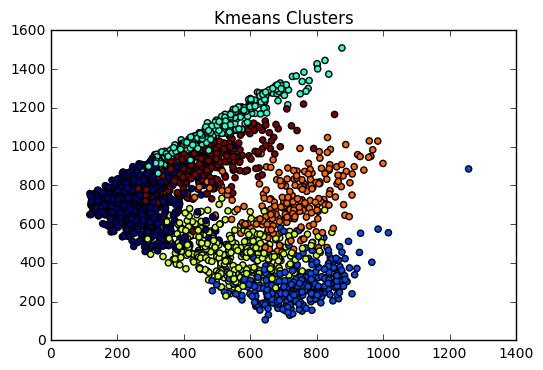

In [235]:
labels = kmeans_model.labels_
plt.scatter(distances[:,0], distances[:,1], c=labels)
plt.title('Kmeans Clusters')
plt.show()

Now add the labels from your clusters into the data set as a new column.  Also add the string "labels" to the `attributes` list, for use later.

In [236]:
df["labels"] = labels
attributes.append("labels")

Before you can build your model, you need to split your data into train and test sets. You do this because if you do decide to train your model on the same data that you test the model, your model can easily overfit the data: the model will more memorize the data instead of learning from it, which resutls in excessively complex models for your data.
That also explains why an overfitted model will perform very poorly when you would try to make predictions with new data. 

But don't worry just yet, there are a number of ways to cross-validate your model. This time, you will simply take a random sample of 75 percent of our data for the `train` data set and use the other 25 percent for your `test` data set.  Create a list `numeric_cols` with all of the columns you will use in your model.  Create a new dataframe `data` from the `df` dataframe with the columns in the `numeric_cols` list.  Create your `train` and `test` data sets by sampling the dataframe `data`.

In [237]:
numeric_cols = ["G","R","AB","H","2B","3B","HR","BB","SO","SB","RA","ER","ERA","CG",
"SHO","SV","IPouts","HA","HRA","BBA","SOA","E","DP","FP","era_1","era_2","era_3","era_4","era_5","era_6","era_7","era_8","decade_1910","decade_1920","decade_1930","decade_1940","decade_1950","decade_1960","decade_1970","decade_1980",
"decade_1990","decade_2000","decade_2010","R_per_game","RA_per_game","mlb_rpg", "labels", "W"]
data = df[numeric_cols]

In [238]:
train = data.sample(frac=0.75, random_state=1)
test = data.loc[~data.index.isin(train.index)]

In [239]:
x_train = train[attributes]
y_train = train["W"]
x_test = test[attributes]
y_test = test["W"]

### Selecting Error Metric and Model

Mean Absolute Error (MAE) is the metric you'll use to determine how accurate your model is. It measures how close the predictions are to the eventual outcomes. Specifically for this data, that means that this error metric will provide you with the average absolute value that your prediction missed it's mark. This means that if, on average, your predictions miss the target amount by 5 wins, your error metric will be 5. 

The first model you will train will be a linear regression model. You can import `LinearRegression` and `mean_absolute_error` from `sklearn.linear_model` and `sklearn.metrics` respectively, and then create a model `lr`.  Next, you'll fit the model, make predictions and determine mean absolute error of the model.

In [240]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
lr = LinearRegression(normalize=True)

In [241]:
lr.fit(x_train, y_train)
predictions = lr.predict(x_test)

In [242]:
mae = mean_absolute_error(y_test, predictions)
print(mae)

2.68692027385


If you recall from above, the average number of wins was about 79 wins. On average, the model is off by only 2.687 wins.  

But maybe you can still do better; Let's try a Ridge regression model.  

Import `RidgeCV` from `sklearn.linear_model` and create model `rrm`.  The `RidgeCV` model allows you to set the alpha parameter, which is a complexity parameter that controls the amount of shrinkage ([read more here](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)).  The model will use cross-validation to deterime which of the alpha parameters you provide is ideal.  Again, fit your model, make predictions and determine the mean absolute error.

In [243]:
from sklearn.linear_model import RidgeCV
rrm = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0), normalize=True)
rrm.fit(x_train, y_train)
predictions_rrm = rrm.predict(x_test)
mae_rrm = mean_absolute_error(y_test, predictions_rrm)
print(mae_rrm)

2.67259187465


This model performed slightly better, and is off by 2.673 wins, on average.

## Sports Analytics & Scikit-Learn

**[Maybe add a general conclusion of your analysis here; What have we learned from the analysis?]**

This concludes the first part of our tutorial series in which you have seen how you can use scikit-Learn to analyze sports data. In the second part, you'll see how to use classification models to predict which players make it into the MLB Hall of Fame. 